# Função auto_arima para estimar modelos AR, MA, ARIMA e SARIMA 

Auto-ARIMA funciona conduzindo testes de diferenciação (ou seja, Kwiatkowski – Phillips – Schmidt – Shin, Augmented Dickey-Fuller ou Phillips – Perron). Se o opcional "sazonal" estiver habilitado, o auto-ARIMA também busca identificar os parâmetros P e Q ideais após realizar o Canova-Hansen para determinar a ordem ótima de diferenciação sazonal. 

Para encontrar o melhor modelo, o auto-ARIMA otimiza para um determinado critério de informação, um dos seguintes ('aic', 'aicc', 'bic', 'hqic', 'oob') (Akaike Information Criterion, Corrected Akaike Information Criterion, Critério de Informação Bayesiano, Critério de Informação de Hannan-Quinn ou “out of bag” – para pontuação de validação – respectivamente) e retorna o ARIMA que minimiza o valor.

In [2]:
# Instalar bibliotecas
!pip install python-bcb pmdarima

In [3]:
# Importar bibliotecas
from bcb import sgs
import pmdarima as pm
from statsmodels.tools.eval_measures import rmse
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
# Carregar dados 
y = sgs.get(
    codes = {"ipca": 433},
    start = "2010-01-01",
    end= "2024-06-01"
)
y

,ipca
Date,
2010-01-01,0.75
2010-02-01,0.78
2010-03-01,0.52
2010-04-01,0.57
2010-05-01,0.43
...,...
2023-12-01,0.56
2024-01-01,0.42
2024-02-01,0.83


In [5]:
y_ts = y.assign(date = y.index).asfreq("MS")
y_ts

,ipca,date
Date,,
2010-01-01,0.75,2010-01-01
2010-02-01,0.78,2010-02-01
2010-03-01,0.52,2010-03-01
2010-04-01,0.57,2010-04-01
2010-05-01,0.43,2010-05-01
...,...,...
2023-12-01,0.56,2023-12-01
2024-01-01,0.42,2024-01-01
2024-02-01,0.83,2024-02-01


In [10]:
y_teste_12_ultimos = y_ts.tail(12)
y_treino_sem_12_ultimos = y_ts.query("date not in @y_teste_12_ultimos.date")

print(y_teste_12_ultimos)
print(y_treino_sem_12_ultimos)

            ipca       date
Date                       
2023-05-01  0.23 2023-05-01
2023-06-01 -0.08 2023-06-01
2023-07-01  0.12 2023-07-01
2023-08-01  0.23 2023-08-01
2023-09-01  0.26 2023-09-01
2023-10-01  0.24 2023-10-01
2023-11-01  0.28 2023-11-01
2023-12-01  0.56 2023-12-01
2024-01-01  0.42 2024-01-01
2024-02-01  0.83 2024-02-01
2024-03-01  0.16 2024-03-01
2024-04-01  0.38 2024-04-01
            ipca       date
Date                       
2010-01-01  0.75 2010-01-01
2010-02-01  0.78 2010-02-01
2010-03-01  0.52 2010-03-01
2010-04-01  0.57 2010-04-01
2010-05-01  0.43 2010-05-01
...          ...        ...
2022-12-01  0.62 2022-12-01
2023-01-01  0.53 2023-01-01
2023-02-01  0.84 2023-02-01
2023-03-01  0.71 2023-03-01
2023-04-01  0.61 2023-04-01

[160 rows x 2 columns]


# Modelo AR usando função auto_arima

In [11]:
modelo = pm.auto_arima(
    y= y_treino_sem_12_ultimos.ipca,
    d= 0, # The order of first-differencing
    start_q = 0, # (default=2) is the order of the moving-average (“MA”) model
    max_p = 10, # (default=5) maximum value of p 
    max_d = 0, # (default=2) maximum value of d, or the maximum number of non-seasonal differences
    max_q = 0, # (default=5) maximum value of q
    seasonal = False
)

In [12]:
# Sumário do modelo
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -34.252
Date:                Tue, 04 Jun 2024   AIC                             74.504
Time:                        22:18:58   BIC                             83.729
Sample:                    01-01-2010   HQIC                            78.250
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2079      0.043      4.853      0.000       0.124       0.292
ar.L1          0.5832      0.060      9.668      0.000       0.465       0.701
sigma2         0.0896      0.007     11.991      0.0

In [29]:
# Produzir previsões
previsao = modelo.predict(y_teste_12_ultimos.shape[0])
previsao

2023-05-01    0.563694
2023-06-01    0.536689
2023-07-01    0.520940
2023-08-01    0.511755
2023-09-01    0.506398
2023-10-01    0.503274
2023-11-01    0.501452
2023-12-01    0.500390
2024-01-01    0.499770
2024-02-01    0.499409
2024-03-01    0.499198
2024-04-01    0.499075
Freq: MS, dtype: float64

In [30]:
y_treino_sem_12_ultimos

,ipca,date
Date,,
2010-01-01,0.75,2010-01-01
2010-02-01,0.78,2010-02-01
2010-03-01,0.52,2010-03-01
2010-04-01,0.57,2010-04-01
2010-05-01,0.43,2010-05-01
...,...,...
2022-12-01,0.62,2022-12-01
2023-01-01,0.53,2023-01-01
2023-02-01,0.84,2023-02-01


In [31]:
# Acurácia de treino e teste
print("RMSE de treino: " + str(rmse(y_treino_sem_12_ultimos.ipca, modelo.fittedvalues())))
print("RMSE de teste: " + str(rmse(y_teste_12_ultimos.ipca, previsao)))

RMSE de treino: 0.29956740478111327
RMSE de teste: 0.3108192131218955


In [32]:
# Gráfico de valores observados e estimados/previstos
resultados = pd.DataFrame(
  data = {
    "date": y_ts.date,
    "y": y_ts.ipca,
    "ajuste": modelo.fittedvalues(),
    "previsao": previsao
    },
  index = y_ts.date
)
resultados

,date,y,ajuste,previsao
date,,,,
2010-01-01,2010-01-01,0.75,0.498903,NaN
2010-02-01,2010-02-01,0.78,0.645341,NaN
2010-03-01,2010-03-01,0.52,0.662837,NaN
2010-04-01,2010-04-01,0.57,0.511207,NaN
2010-05-01,2010-05-01,0.43,0.540366,NaN
...,...,...,...,...
2023-12-01,2023-12-01,0.56,NaN,0.500390
2024-01-01,2024-01-01,0.42,NaN,0.499770
2024-02-01,2024-02-01,0.83,NaN,0.499409


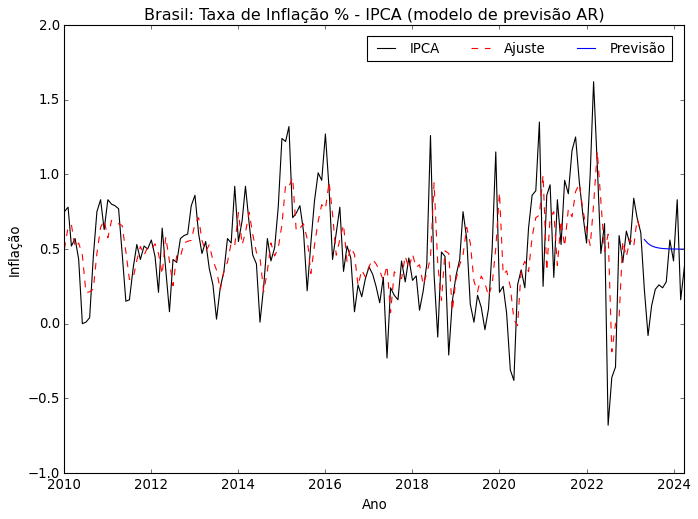

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(resultados["date"], resultados["y"], color = "black", label = "IPCA")
ax.plot(resultados["date"], resultados["ajuste"], color ="red", linestyle = "--", label = "Ajuste")
ax.plot(resultados["date"], resultados["previsao"], color ="blue", label = "Previsão")
ax.set_title("Brasil: Taxa de Inflação % - IPCA (modelo de previsão AR)")
ax.set_xlabel("Ano")
ax.set_ylabel("Inflação")
ax.legend(
          bbox_to_anchor=(0.99,0.99),
          labelspacing=1,
          ncol=3, fontsize=12)
plt.show()

# MA 

In [53]:
modelo_ma = pm.auto_arima(
    y= y_treino_sem_12_ultimos.ipca,
    start_p = 0, # (default=2) order (or number of time lags) of the auto-regressive (“AR”) model.
    d = 0, 
    max_p = 0,
    max_d = 0,
    seasonal = False
)
# Sumário do modelo
print(modelo_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(0, 0, 4)   Log Likelihood                 -32.527
Date:                Tue, 04 Jun 2024   AIC                             77.055
Time:                        22:29:15   BIC                             95.506
Sample:                    01-01-2010   HQIC                            84.547
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4984      0.060      8.350      0.000       0.381       0.615
ma.L1          0.5649      0.069      8.209      0.000       0.430       0.700
ma.L2          0.3596      0.081      4.464      0.0

In [55]:
# Produzir previsões
previsao_ma = modelo_ma.predict(y_teste_12_ultimos.shape[0])
previsao_ma

2023-05-01    0.590340
2023-06-01    0.560915
2023-07-01    0.502791
2023-08-01    0.495085
2023-09-01    0.498400
2023-10-01    0.498400
2023-11-01    0.498400
2023-12-01    0.498400
2024-01-01    0.498400
2024-02-01    0.498400
2024-03-01    0.498400
2024-04-01    0.498400
Freq: MS, dtype: float64

In [56]:
# Acurácia de treino e teste
print("RMSE de treino: " + str(rmse(y_treino_sem_12_ultimos.ipca, modelo_ma.fittedvalues())))
print("RMSE de teste: " + str(rmse(y_teste_12_ultimos.ipca, previsao_ma)))

RMSE de treino: 0.2963058467263842
RMSE de teste: 0.3132028227088955


In [57]:
# Gráfico de valores observados e estimados/previstos
resultados_ma = pd.DataFrame(
  data = {
    "date": y_ts.date,
    "y": y_ts.ipca,
    "ajuste": modelo_ma.fittedvalues(),
    "previsao": previsao_ma
    },
  index = y_ts.date
)

resultados_ma

,date,y,ajuste,previsao
date,,,,
2010-01-01,2010-01-01,0.75,0.498400,NaN
2010-02-01,2010-02-01,0.78,0.646949,NaN
2010-03-01,2010-03-01,0.52,0.668045,NaN
2010-04-01,2010-04-01,0.57,0.523571,NaN
2010-05-01,2010-05-01,0.43,0.536277,NaN
...,...,...,...,...
2023-12-01,2023-12-01,0.56,NaN,0.4984
2024-01-01,2024-01-01,0.42,NaN,0.4984
2024-02-01,2024-02-01,0.83,NaN,0.4984


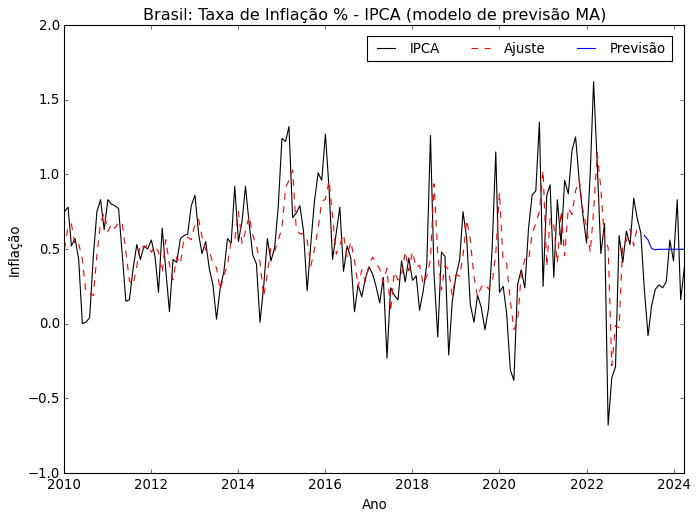

In [71]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(resultados_ma["date"], resultados_ma["y"], color = "black", label = "IPCA")
ax.plot(resultados_ma["date"], resultados_ma["ajuste"], color ="red", linestyle = "--", label = "Ajuste")
ax.plot(resultados_ma["date"], resultados_ma["previsao"], color ="blue", label = "Previsão")
ax.set_title("Brasil: Taxa de Inflação % - IPCA (modelo de previsão MA)")
ax.set_xlabel("Ano")
ax.set_ylabel("Inflação")
ax.legend(
          bbox_to_anchor=(0.99,0.99),
          labelspacing=1,
          ncol=3, fontsize=12)
plt.show()

# ARIMA

In [59]:
modelo_arima = pm.auto_arima(
    y= y_treino_sem_12_ultimos.ipca,
    seasonal = False
)
# Sumário do modelo
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(0, 0, 4)   Log Likelihood                 -32.527
Date:                Tue, 04 Jun 2024   AIC                             77.055
Time:                        22:29:37   BIC                             95.506
Sample:                    01-01-2010   HQIC                            84.547
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4984      0.060      8.350      0.000       0.381       0.615
ma.L1          0.5649      0.069      8.209      0.000       0.430       0.700
ma.L2          0.3596      0.081      4.464      0.0

In [60]:
# Produzir previsões
previsao_arima = modelo_arima.predict(y_teste_12_ultimos.shape[0])
previsao_arima

2023-05-01    0.590340
2023-06-01    0.560915
2023-07-01    0.502791
2023-08-01    0.495085
2023-09-01    0.498400
2023-10-01    0.498400
2023-11-01    0.498400
2023-12-01    0.498400
2024-01-01    0.498400
2024-02-01    0.498400
2024-03-01    0.498400
2024-04-01    0.498400
Freq: MS, dtype: float64

In [61]:
# Acurácia de treino e teste
print("RMSE de treino: " + str(rmse(y_treino_sem_12_ultimos.ipca, modelo_arima.fittedvalues())))
print("RMSE de teste: " + str(rmse(y_teste_12_ultimos.ipca, previsao_arima)))

RMSE de treino: 0.2963058467263842
RMSE de teste: 0.3132028227088955


In [62]:
# Gráfico de valores observados e estimados/previstos
resultados_arima = pd.DataFrame(
  data = {
    "date": y_ts.date,
    "y": y_ts.ipca,
    "ajuste": modelo_arima.fittedvalues(),
    "previsao": previsao_arima
    },
  index = y_ts.date
)

resultados_arima

,date,y,ajuste,previsao
date,,,,
2010-01-01,2010-01-01,0.75,0.498400,NaN
2010-02-01,2010-02-01,0.78,0.646949,NaN
2010-03-01,2010-03-01,0.52,0.668045,NaN
2010-04-01,2010-04-01,0.57,0.523571,NaN
2010-05-01,2010-05-01,0.43,0.536277,NaN
...,...,...,...,...
2023-12-01,2023-12-01,0.56,NaN,0.4984
2024-01-01,2024-01-01,0.42,NaN,0.4984
2024-02-01,2024-02-01,0.83,NaN,0.4984


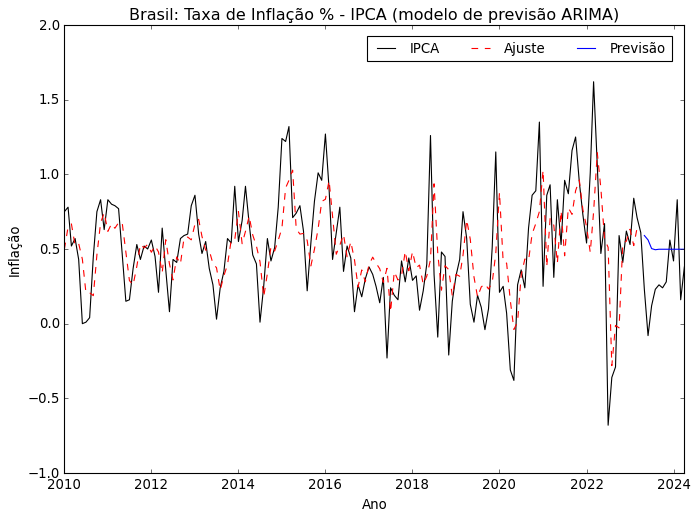

In [70]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(resultados_arima["date"], resultados_arima["y"], color = "black", label = "IPCA")
ax.plot(resultados_arima["date"], resultados_arima["ajuste"], color ="red", linestyle = "--", label = "Ajuste")
ax.plot(resultados_arima["date"], resultados_arima["previsao"], color ="blue", label = "Previsão")
ax.set_title("Brasil: Taxa de Inflação % - IPCA (modelo de previsão ARIMA)")
ax.set_xlabel("Ano")
ax.set_ylabel("Inflação")
ax.legend(
          bbox_to_anchor=(0.99,0.99),
          labelspacing=1,
          ncol=3, fontsize=12)
plt.show()

# SARIMA

In [64]:
modelo_sarima = pm.auto_arima(
    y= y_treino_sem_12_ultimos.ipca,
    seasonal = True,
    m=12
)
# Sumário do modelo
print(modelo_sarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -34.252
Date:                Tue, 04 Jun 2024   AIC                             74.504
Time:                        22:30:54   BIC                             83.729
Sample:                    01-01-2010   HQIC                            78.250
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2079      0.043      4.853      0.000       0.124       0.292
ar.L1          0.5832      0.060      9.668      0.000       0.465       0.701
sigma2         0.0896      0.007     11.991      0.0

In [65]:
# Produzir previsões
previsao_sarima = modelo_sarima.predict(y_teste_12_ultimos.shape[0])
previsao_sarima

2023-05-01    0.563694
2023-06-01    0.536689
2023-07-01    0.520940
2023-08-01    0.511755
2023-09-01    0.506398
2023-10-01    0.503274
2023-11-01    0.501452
2023-12-01    0.500390
2024-01-01    0.499770
2024-02-01    0.499409
2024-03-01    0.499198
2024-04-01    0.499075
Freq: MS, dtype: float64

In [66]:
# Acurácia de treino e teste
print("RMSE de treino: " + str(rmse(y_treino_sem_12_ultimos.ipca, modelo_sarima.fittedvalues())))
print("RMSE de teste: " + str(rmse(y_teste_12_ultimos.ipca, previsao_sarima)))

RMSE de treino: 0.29956740478111327
RMSE de teste: 0.3108192131218955


In [67]:
# Gráfico de valores observados e estimados/previstos
resultados_sarima = pd.DataFrame(
  data = {
    "date": y_ts.date,
    "y": y_ts.ipca,
    "ajuste": modelo_sarima.fittedvalues(),
    "previsao": previsao_sarima
    },
  index = y_ts.date
)

resultados_sarima

,date,y,ajuste,previsao
date,,,,
2010-01-01,2010-01-01,0.75,0.498903,NaN
2010-02-01,2010-02-01,0.78,0.645341,NaN
2010-03-01,2010-03-01,0.52,0.662837,NaN
2010-04-01,2010-04-01,0.57,0.511207,NaN
2010-05-01,2010-05-01,0.43,0.540366,NaN
...,...,...,...,...
2023-12-01,2023-12-01,0.56,NaN,0.500390
2024-01-01,2024-01-01,0.42,NaN,0.499770
2024-02-01,2024-02-01,0.83,NaN,0.499409


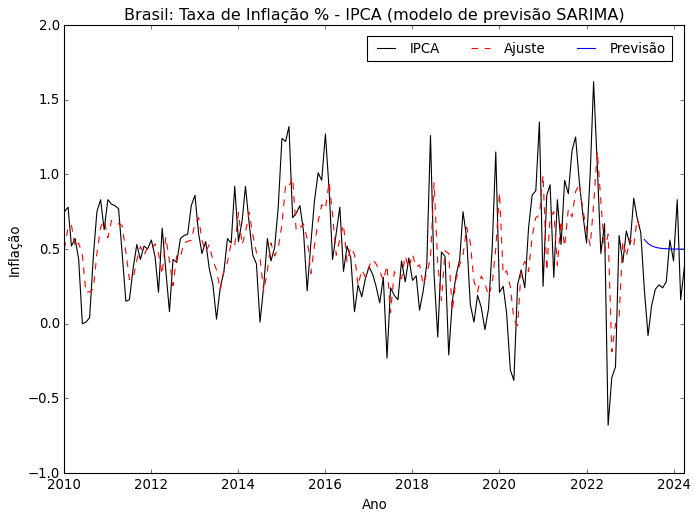

In [82]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(resultados_sarima["date"], resultados_sarima["y"], color = "black", label = "IPCA")
ax.plot(resultados_sarima["date"], resultados_sarima["ajuste"], color ="red", linestyle = "--", label = "Ajuste")
ax.plot(resultados_sarima["date"], resultados_sarima["previsao"], color ="blue", label = "Previsão")
ax.set_title("Brasil: Taxa de Inflação % - IPCA (modelo de previsão SARIMA)")
ax.set_xlabel("Ano")
ax.set_ylabel("Inflação")
ax.legend(
          bbox_to_anchor=(0.99,0.99),
          labelspacing=1,
          ncol=3, fontsize=12)
plt.show()